In [1]:
%load_ext autoreload
%autoreload 2

from jordan_wigner import jw_majoranas
from electronic_hamiltonian import quadratic_terms
from qiskit.quantum_info import PauliList
from tableau import spread_node, spread_node_slice, anticommutation_matrix
import random
from cost_functions import weight, quadratic_term_mean_weight, quartic_term_mean_weight
from annealing import anneal
import matplotlib.pyplot as plt

In [14]:
from electronic_hamiltonian import quartic_terms

N = 100

x, z = jw_majoranas(N)

paulis = PauliList.from_symplectic(z, x)

print("Majorana Operators:", paulis)

x_terms, z_terms = quadratic_terms(x, z, N)
quadratic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quadratic Hamiltonian Terms:", quadratic_terms_paulis)

x_terms, z_terms = quartic_terms(x, z, N)
quartic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quartic Hamiltonian Terms:", quartic_terms_paulis)

print(f"Average Weight: {weight(x, z)}")

Majorana Operators: ['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

Initial temperature T0 = 0.1585
Iteration 3: New optimal energy = 34.207071
Iteration 12: New optimal energy = 33.965455
Iteration 16: New optimal energy = 33.628283
Iteration 28: New optimal energy = 33.276162
Iteration 31: New optimal energy = 33.138586
Iteration 37: New optimal energy = 33.090303
Iteration 47: New optimal energy = 33.019192
Iteration 49: New optimal energy = 32.535354
Iteration 52: New optimal energy = 32.453131
Iteration 54: New optimal energy = 32.203838
Iteration 60: New optimal energy = 32.044444
Iteration 62: New optimal energy = 32.041616
Iteration 66: New optimal energy = 31.698990
Iteration 71: New optimal energy = 31.640808
Iteration 75: New optimal energy = 31.431919
Iteration 96: New optimal energy = 31.129495
Iteration 105: New optimal energy = 30.936162
Iteration 120: New optimal energy = 30.849293
Iteration 128: New optimal energy = 30.612929
Iteration 134: New optimal energy = 30.460202
Iteration 140: New optimal energy = 30.417576
Iteration 152: New 

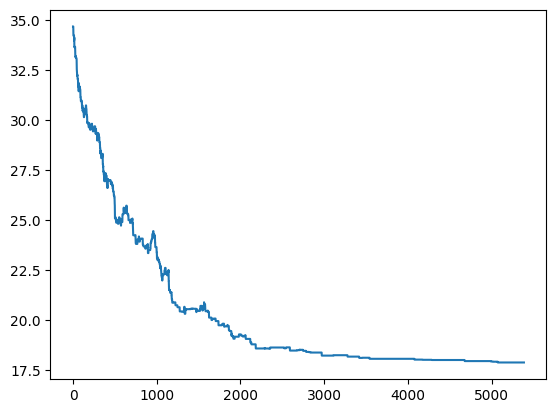

In [15]:
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9995)

paulis = PauliList.from_symplectic(z, x)

plt.plot(energies)

In [9]:
anticommutation_matrix(x, z)

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,